In [1]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path)

import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random

from pygents.aigents_api import TextMetrics, load_ngrams
from pygents.plot import plot_dict, plot_dict_bars, matrix_plot
from pygents.util import dictcount


In [2]:
# Dataset: Multiple Distorions (sagarikashreevastava)
# Paper: https://aclanthology.org/2021.clpsych-1.17/
# Data: https://www.kaggle.com/datasets/sagarikashreevastava/cognitive-distortion-detetction-dataset

# !pip install kagglehub
import kagglehub
multiclass_dataset_path = kagglehub.dataset_download("sagarikashreevastava/cognitive-distortion-detetction-dataset")
print("Path to dataset files:", multiclass_dataset_path)
multiclass_dataset_file_path = multiclass_dataset_path + "/Annotated_data.csv"


Path to dataset files: /Users/akolonin/.cache/kagglehub/datasets/sagarikashreevastava/cognitive-distortion-detetction-dataset/versions/1


## Explore performance of "our out of the box" model with dataset 2 (original multi-class)

In [3]:
df3 = pd.read_csv(multiclass_dataset_file_path) 
df3 = df3.drop('Id_Number', axis=1) # delete columnb with id 

#df3 = df3[0:5] # hack for test!

df3


,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,"Hello, I have a beautiful,smart,outgoing and a...",The voice are always fimilar (someone she know...,Personalization,NaN
1,Since I was about 16 years old I’ve had these ...,I feel trapped inside my disgusting self and l...,Labeling,Emotional Reasoning
2,So I’ve been dating on and off this guy for a...,NaN,No Distortion,NaN
3,My parents got divorced in 2004. My mother has...,NaN,No Distortion,NaN
4,I don’t really know how to explain the situati...,I refused to go because I didn’t know if it wa...,Fortune-telling,Emotional Reasoning
...,...,...,...,...
2525,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN
2526,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN
2527,From the U.S.: My brother is 19 years old and ...,He claims he’s severely depressed and has outb...,Mental filter,Mind Reading
2528,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN


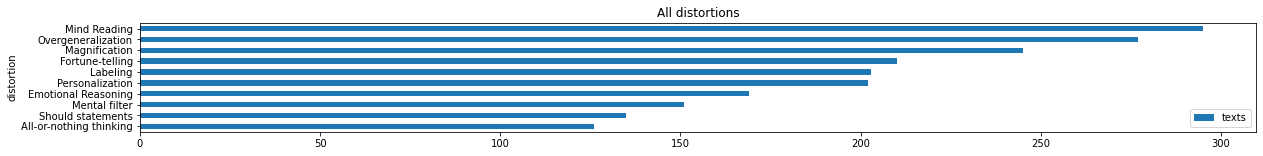

In [4]:
dists = {}
for _, row in df3.iterrows():
        # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
        text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
        primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
        secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else 'No Distortion'  # The secondary distortion from the 4th column, if it exists
        ground_distortions = []
        if primary_distortion != 'No Distortion':
            ground_distortions.append(primary_distortion)
        if secondary_distortion != 'No Distortion':
            ground_distortions.append(secondary_distortion)
        for d in ground_distortions:
            dictcount(dists,d)
        
plot_dict(
    dists,
    labels="distortion",
    values="texts",
    title="All distortions",
    head=20
)

In [5]:
df3s = [ df3.iloc[:0,:].copy(), df3.iloc[:0,:].copy(), df3.iloc[:0,:].copy()]

row_n = 0 
for _, row in df3.iterrows():
    r3 = row_n % 3
    row_n += 1
    df = df3s[r3]
    df.loc[len(df)] = row

print(len(df3))
for df in df3s:
    print(len(df), len(df)*2)

2530
844 1688
843 1686
843 1686


In [6]:
all_metrics = ['All-or-nothing_thinking','Fortune-telling','Mental_filter','Overgeneralization','Labeling',
          'Mind_Reading','Personalization','Emotional_Reasoning','Magnification','Should_statements']

def language_metrics(lang,metrics_list,path):
    metrics = {}
    for m in metrics_list:
        metrics[m] = path + lang + '/' + m + '.txt'
    return metrics

def our_evaluator_test(expected_distortions,text,threshold):
    dic = {}
    for m in all_metrics:
        dic[m] = True if (m in expected_distortions) else False
    return dic

def our_evaluator_tm(tm,text,threshold):
    metrics = tm.get_sentiment_words(text)
    dic = {}
    for m in all_metrics:
        dic[m] = True if m in metrics and metrics[m] > threshold else False
    return dic

def our_evaluator_true(tm,text,threshold):
    dic = {}
    for m in all_metrics:
        dic[m] = True
    return dic
    
def our_evaluator_false(tm,text,threshold):
    dic = {}
    for m in all_metrics:
        dic[m] = False
    return dic

def our_evaluator_random(tm,text,threshold):
    dic = {}
    for m in all_metrics:
        dic[m] = random.choice([True, False])
    return dic

def dictval(dic,key,val):
    return dic[key] if key in dic else val 

def pre_rec_f1_from_counts(true_positive, true_negative, false_positive, false_negative):
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    return precision, recall, 2 * precision * recall / (precision + recall) if precision > 0 or recall > 0 else 0 

def evaluate_tm_df(df,tm,evaluator,threshold,debug=False):
    true_positives = {}
    true_negatives = {}
    false_positives = {}
    false_negatives = {}
    pre = {}
    rec = {}
    f1 = {}
    acc = {}
    for _, row in df.iterrows():
        # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
        text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
        primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
        secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else 'No Distortion'  # The secondary distortion from the 4th column, if it exists
        ground_distortions = []
        if primary_distortion != 'No Distortion':
            ground_distortions.append(primary_distortion.replace(' ','_'))
        if secondary_distortion != 'No Distortion':
            ground_distortions.append(secondary_distortion.replace(' ','_'))

        if evaluator == our_evaluator_test:
            distortions_by_metric = evaluator(ground_distortions,text,threshold) #hack to test metrics
        else:
            distortions_by_metric = evaluator(tm,text,threshold)

        if debug:
            print(ground_distortions,'=>',[m for m in distortions_by_metric if distortions_by_metric[m]])
        
        for metric in distortions_by_metric:
            our_distortion = distortions_by_metric[metric]
            if (metric in ground_distortions) and our_distortion == True:
                dictcount(true_positives,metric)
            if (not metric in ground_distortions) and our_distortion == True:
                dictcount(false_positives,metric)
            if (not metric in ground_distortions) and our_distortion == False:
                dictcount(true_negatives,metric)
            if (metric in ground_distortions) and our_distortion == False:
                dictcount(false_negatives,metric)

    if debug:
        #print()
        print('TP:',true_positives)
        print('FP:',false_positives)
        print('TN:',true_negatives)
        print('FN:',false_negatives)
    
    for metric in all_metrics:
        precision, recall, f1score = pre_rec_f1_from_counts(dictval(true_positives,metric,0), dictval(true_negatives,metric,0), 
                                   dictval(false_positives,metric,0), dictval(false_negatives,metric,0))
        pre[metric] = precision
        rec[metric] = recall
        f1[metric] = f1score
        acc[metric] = (dictval(true_positives,metric,0) + dictval(true_negatives,metric,0)) / len(df)
    
    return pre, rec, f1, acc


def matrix_plot(row_labels, col_labels, matrix, absmax, title = None, vmin = None, vmax = None, dpi = None, titlefontsize = None, width = 20):
    plt.rcParams["figure.figsize"] = (width,len(row_labels)/4)
    if not dpi is None:
        plt.rcParams["figure.dpi"] = dpi
    p = sns.heatmap(matrix, xticklabels=col_labels, yticklabels=row_labels, 
                    vmin = -absmax if vmin is None else vmin, 
                    vmax = absmax if vmax is None else vmax, 
                    cmap='RdYlGn', annot=True)
    if title is not None:
        if titlefontsize is None:
            titlefontsize = 32 if len(title) < 50 else round(32 * 50 / len(title))
        p.set_title(title,fontsize = titlefontsize)
    plt.show()


In [7]:
models = {}

models['Ours new (multi-class, joint), log'] = TextMetrics(language_metrics('',all_metrics,
                                            path='./data/models/distortions/split_combined/multiclass_view_cleaned/joint/'),
                                            encoding="utf-8",metric_logarithmic=True,debug=False)

models['Ours new (multi-class, joint), no log'] = TextMetrics(language_metrics('',all_metrics,
                                            path='./data/models/distortions/split_combined/multiclass_view_cleaned/joint/'),
                                            encoding="utf-8",metric_logarithmic=False,debug=False)


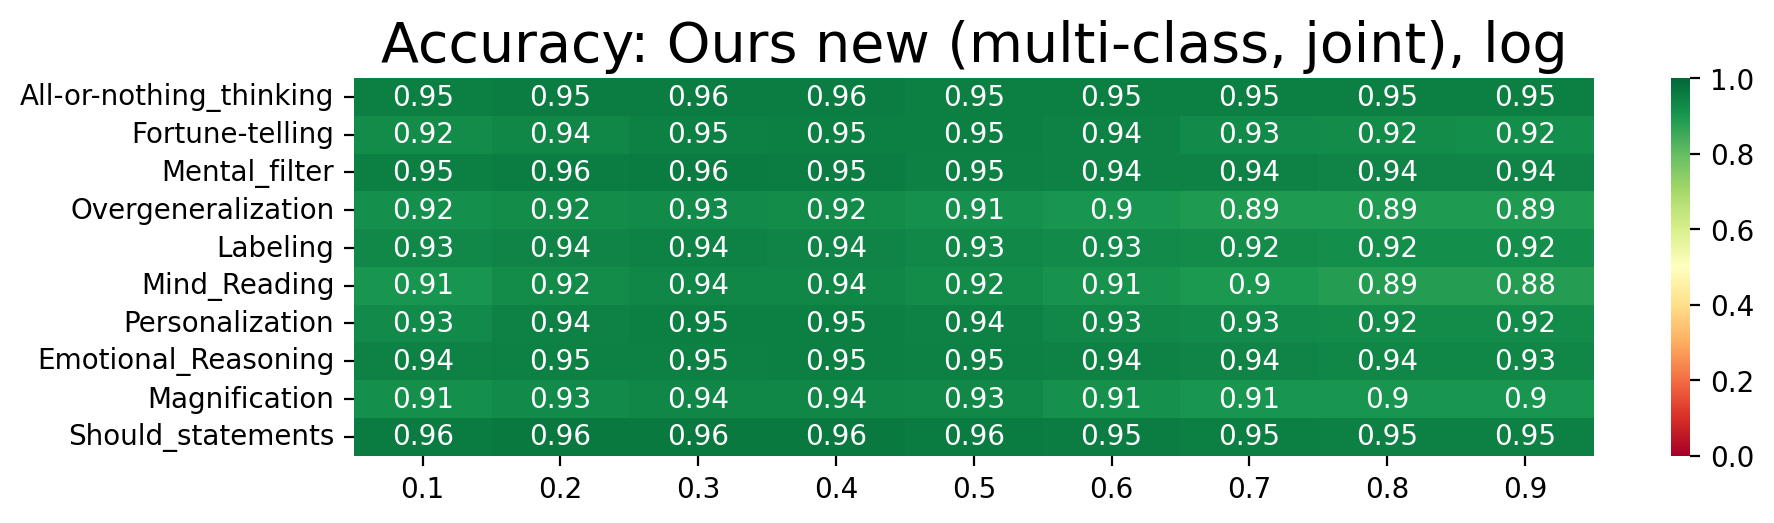

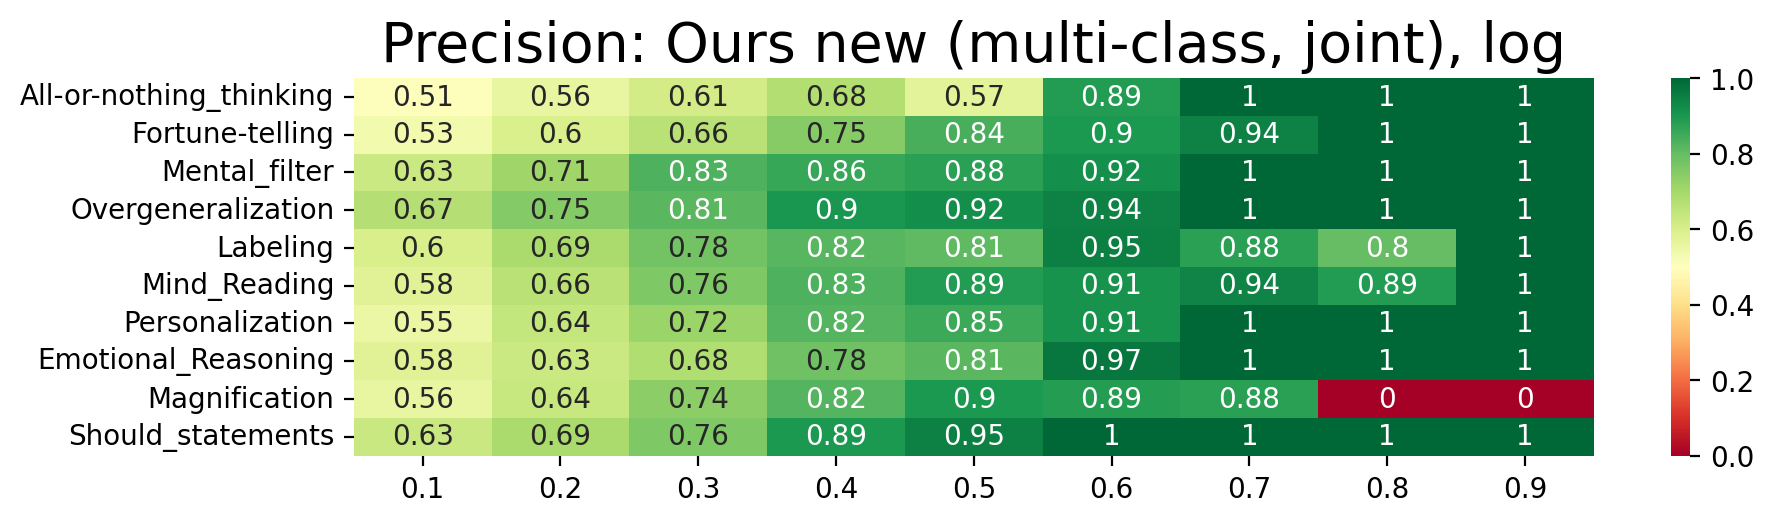

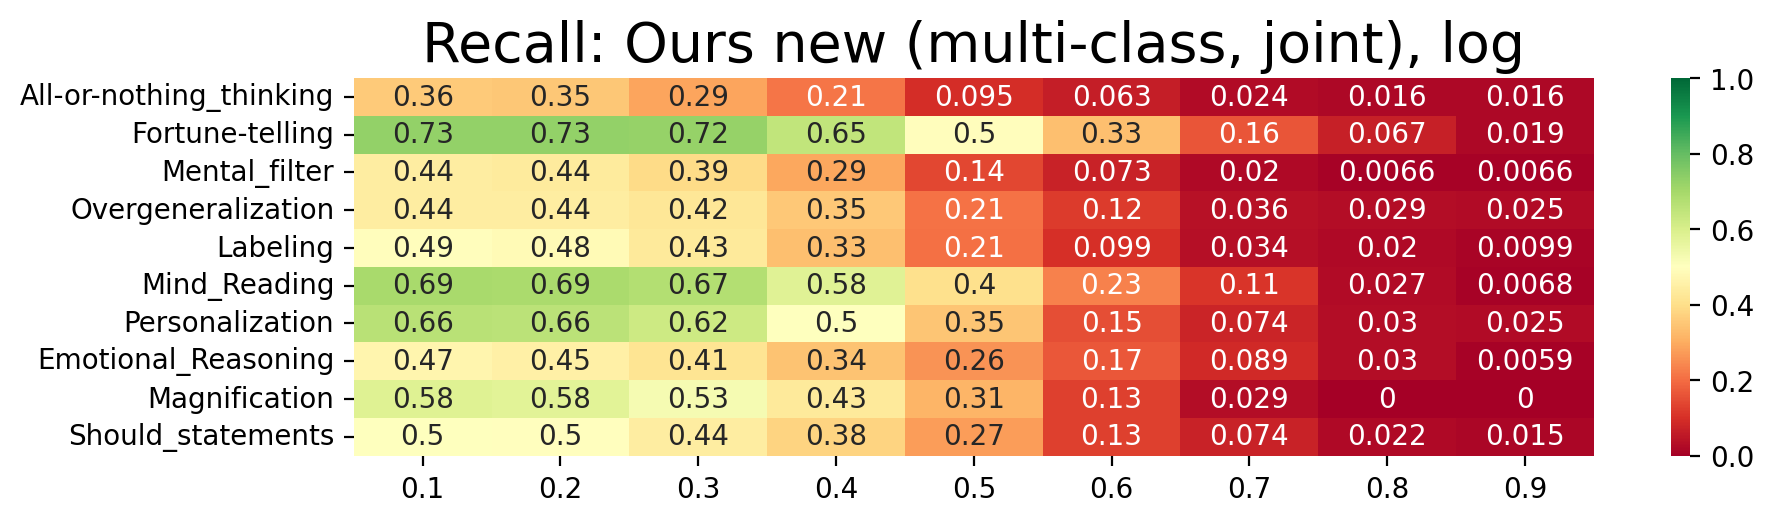

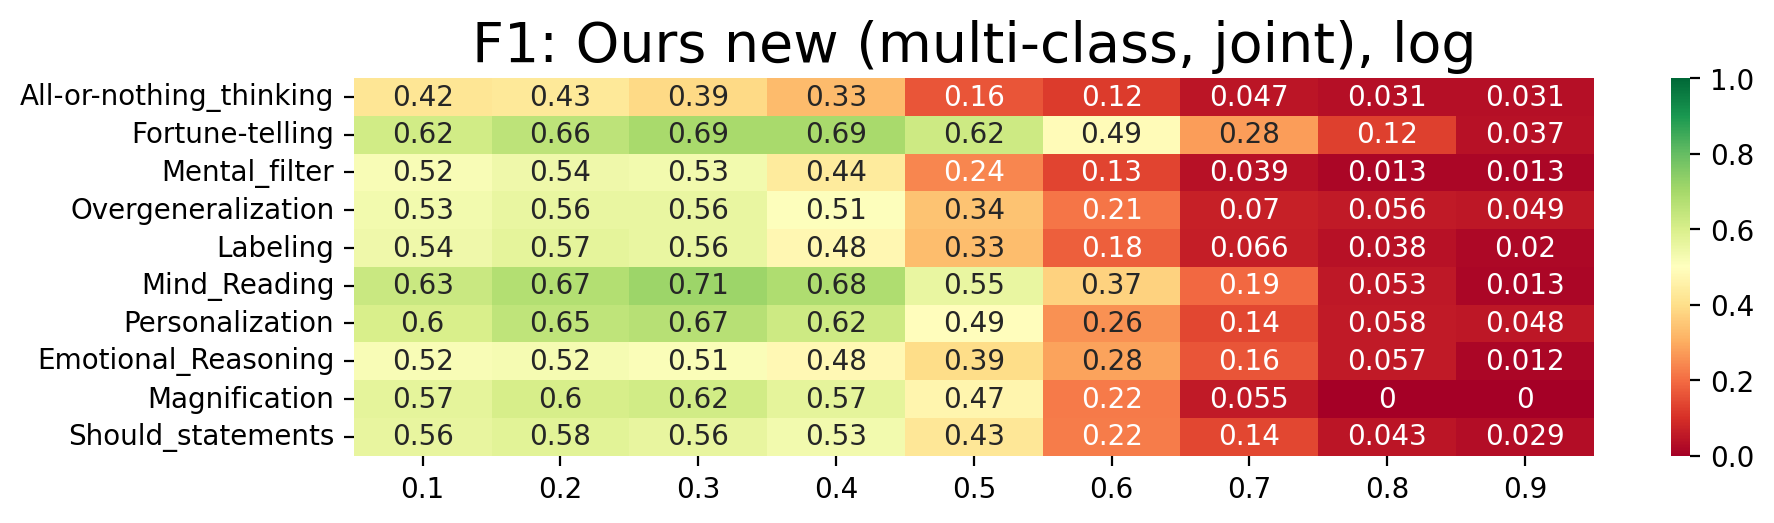

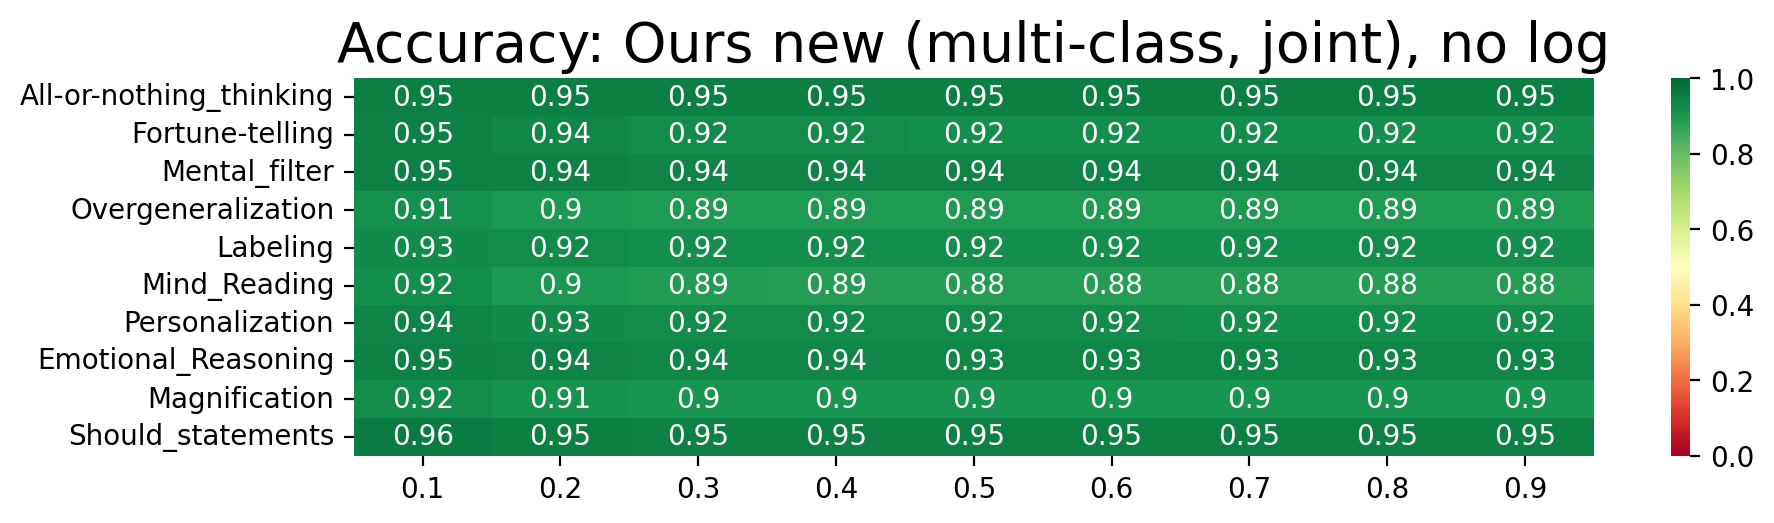

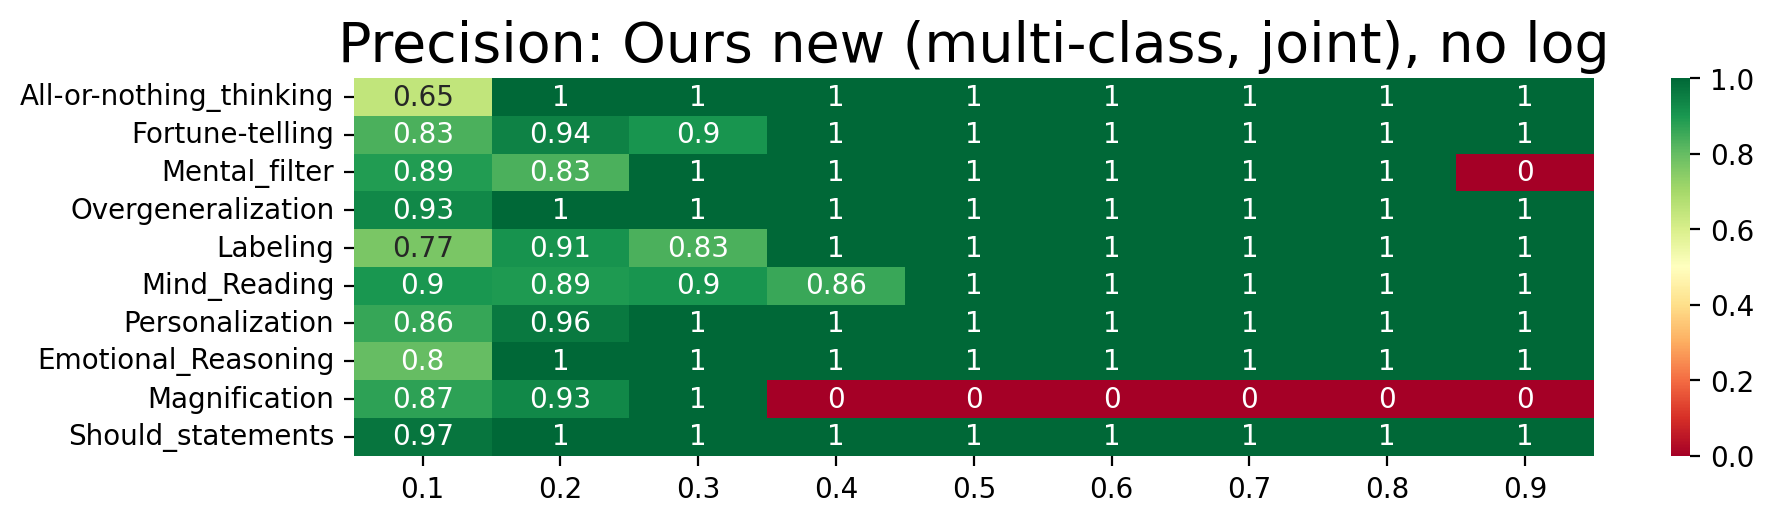

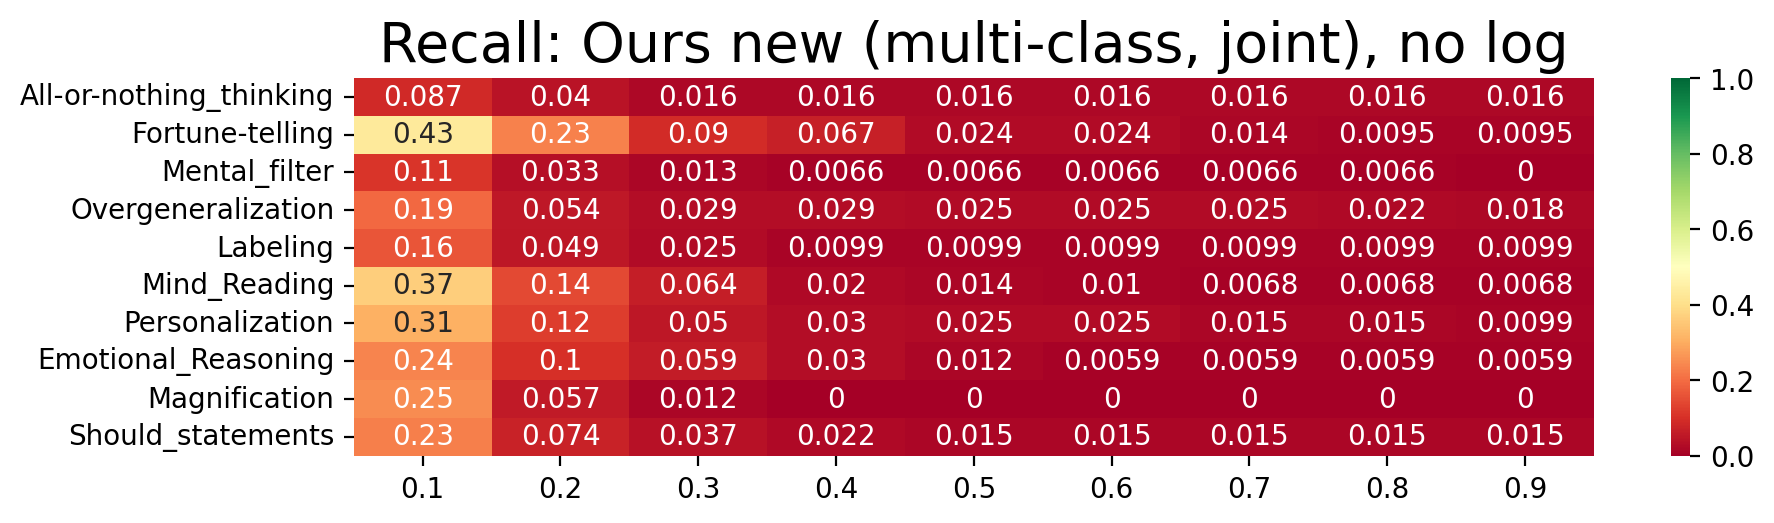

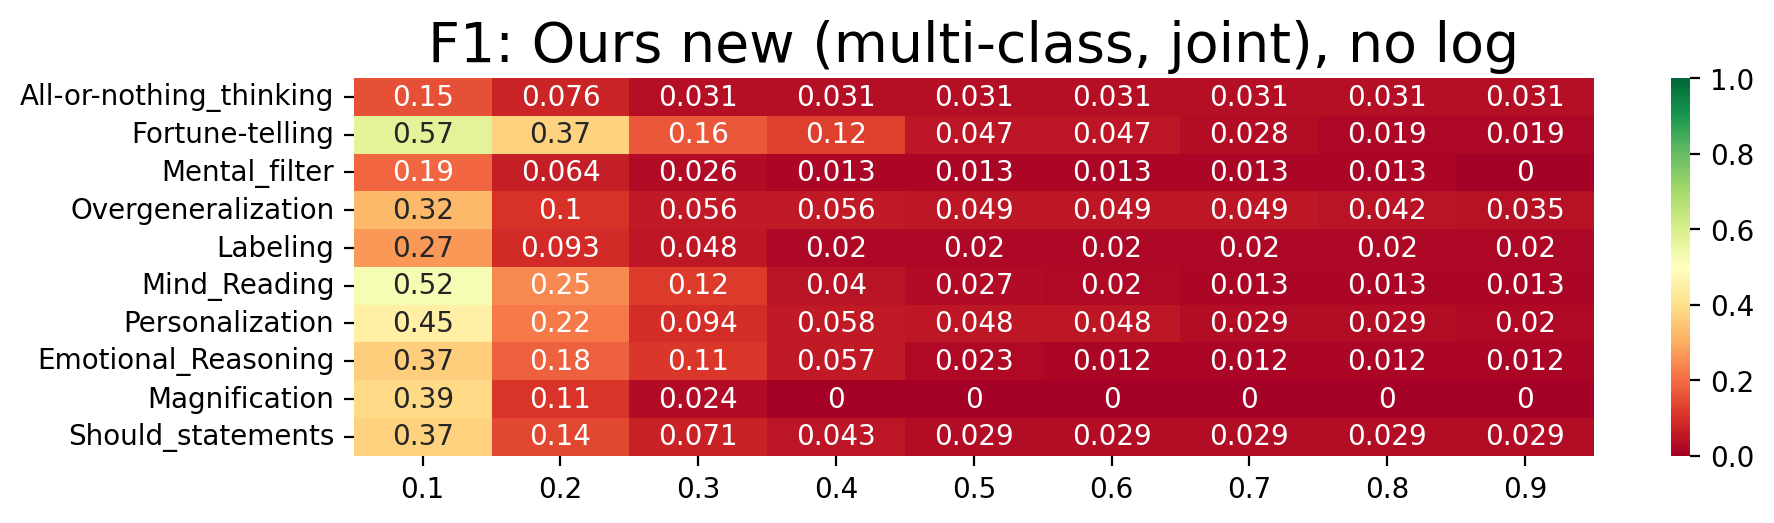

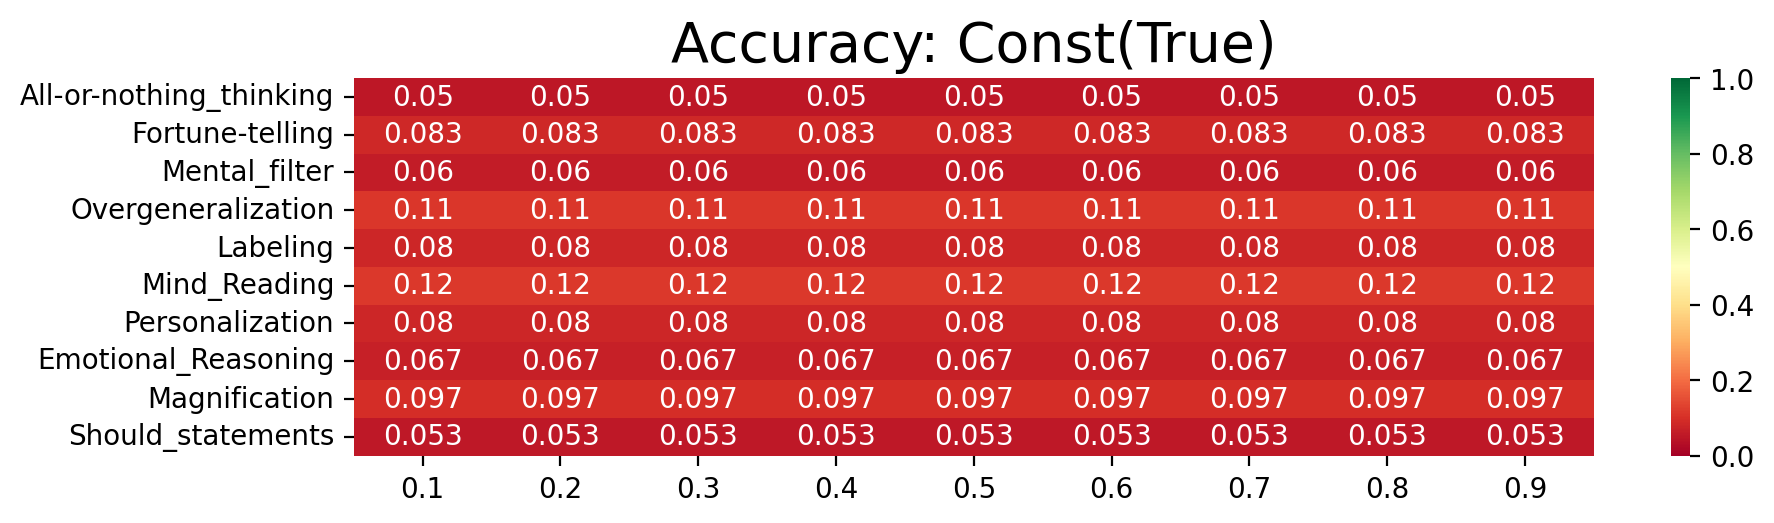

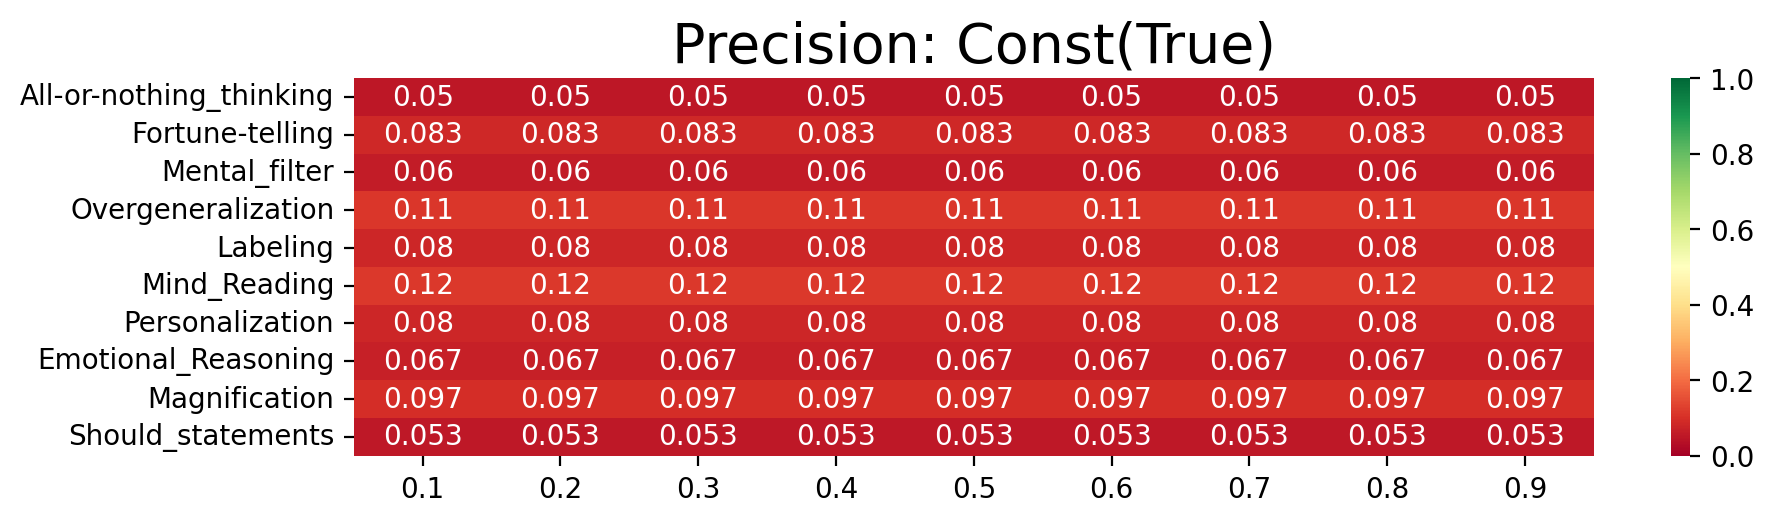

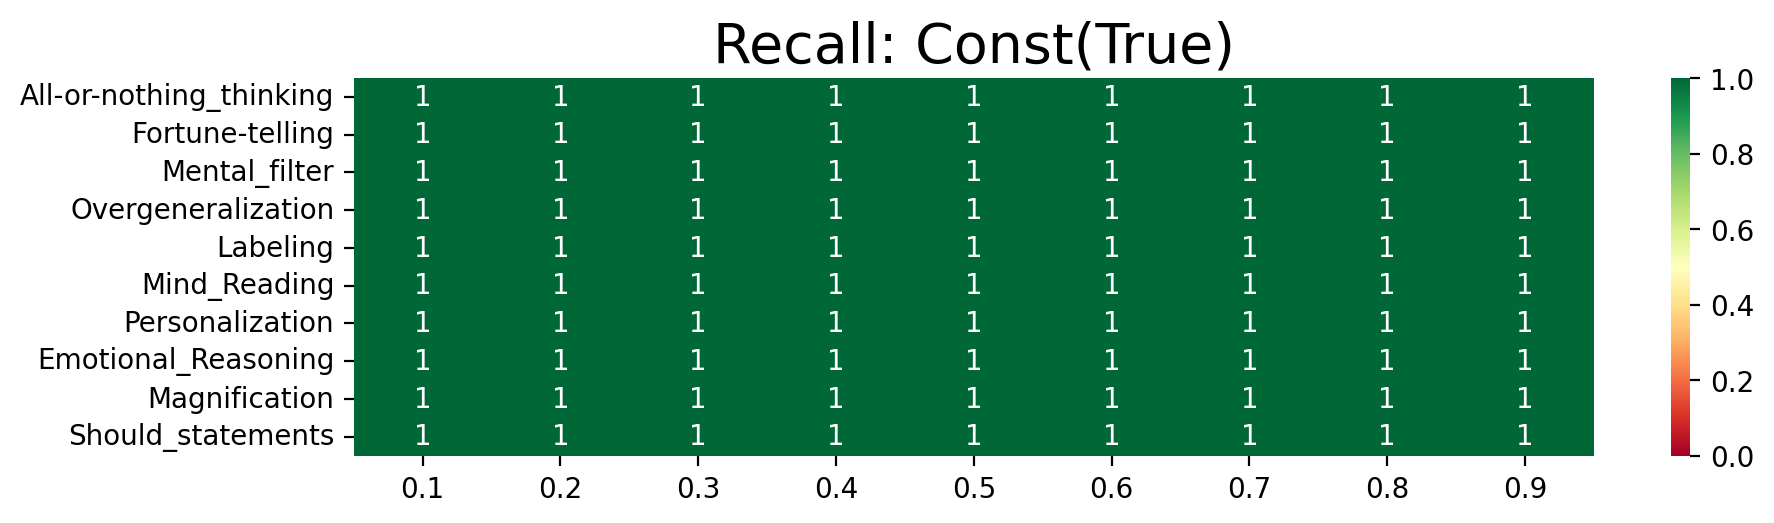

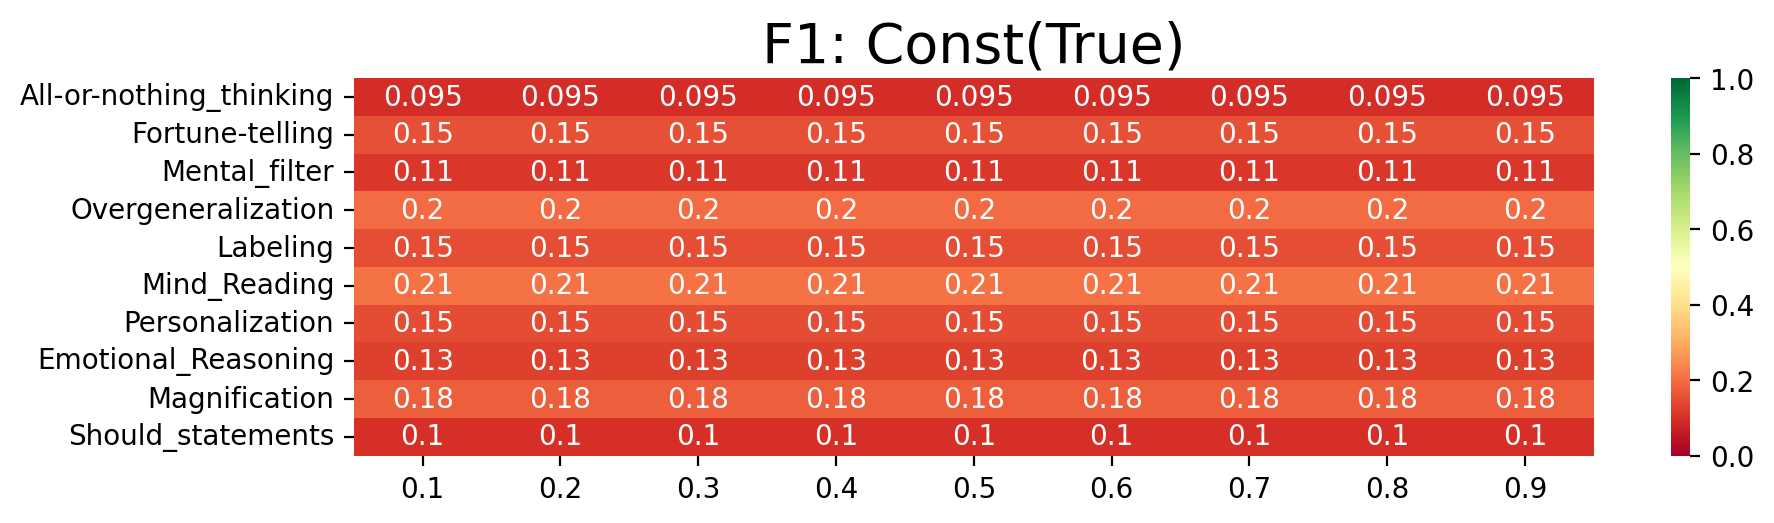

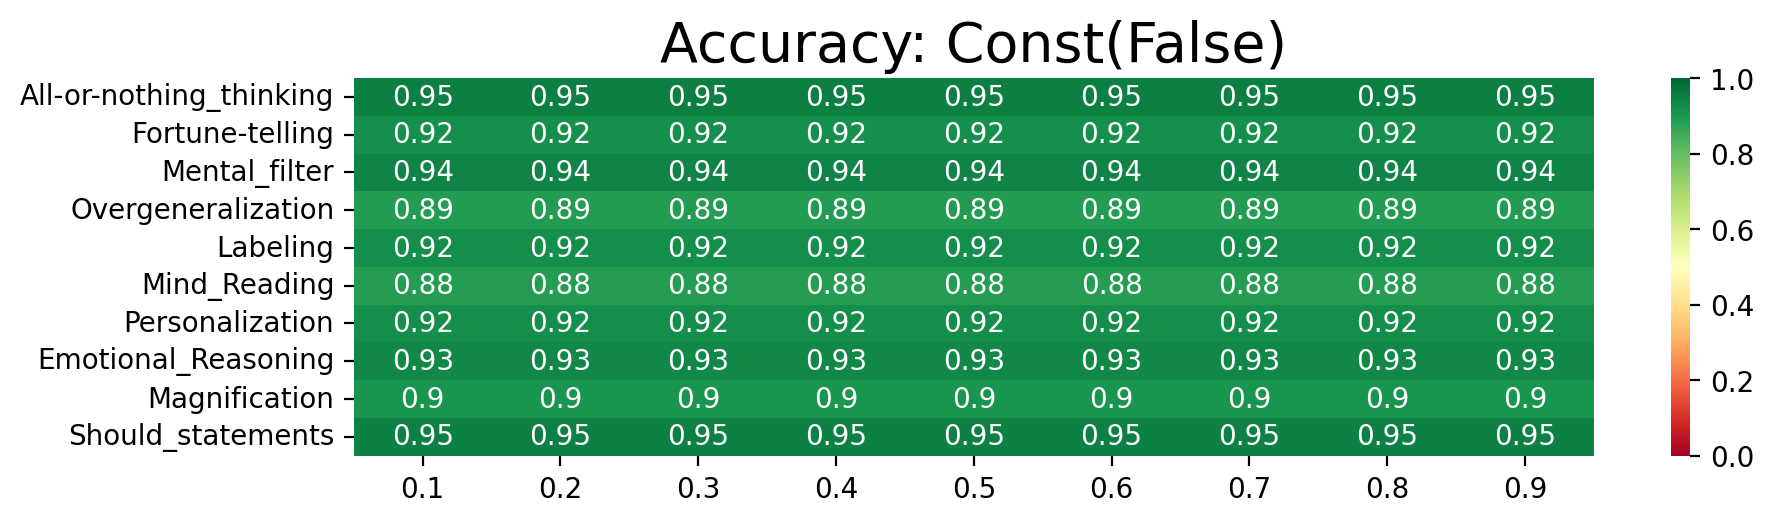

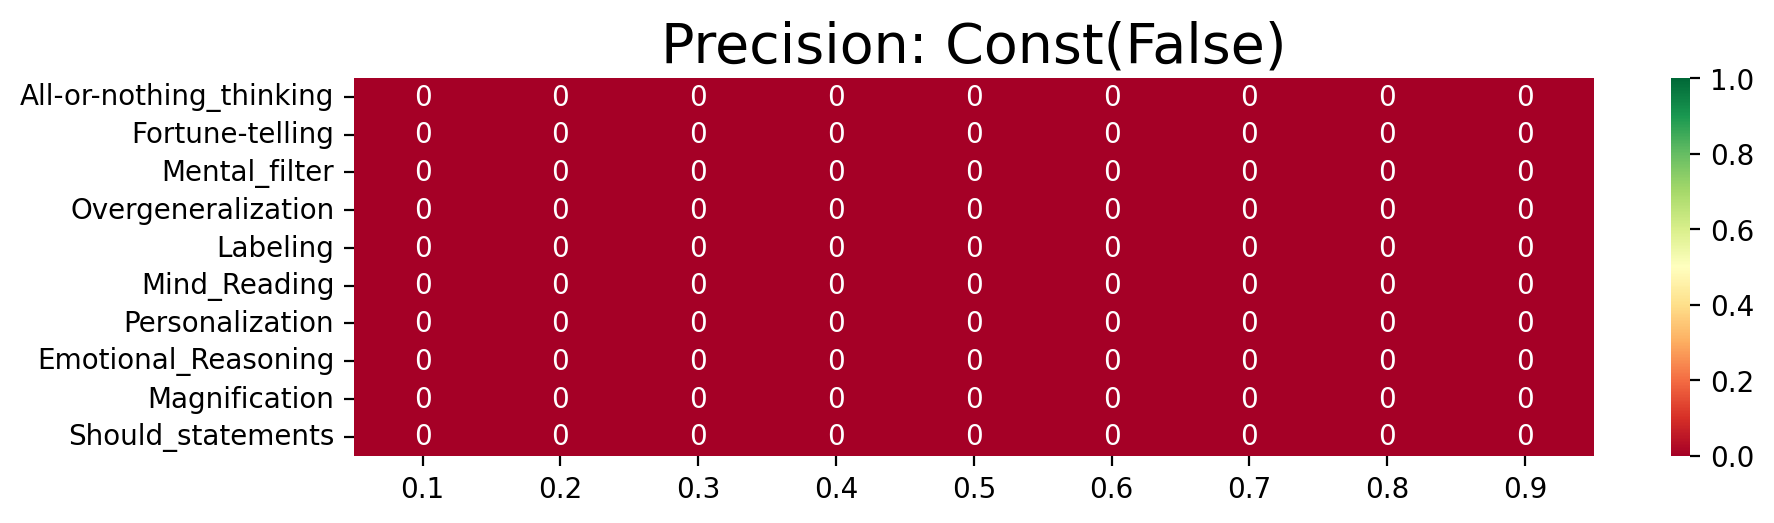

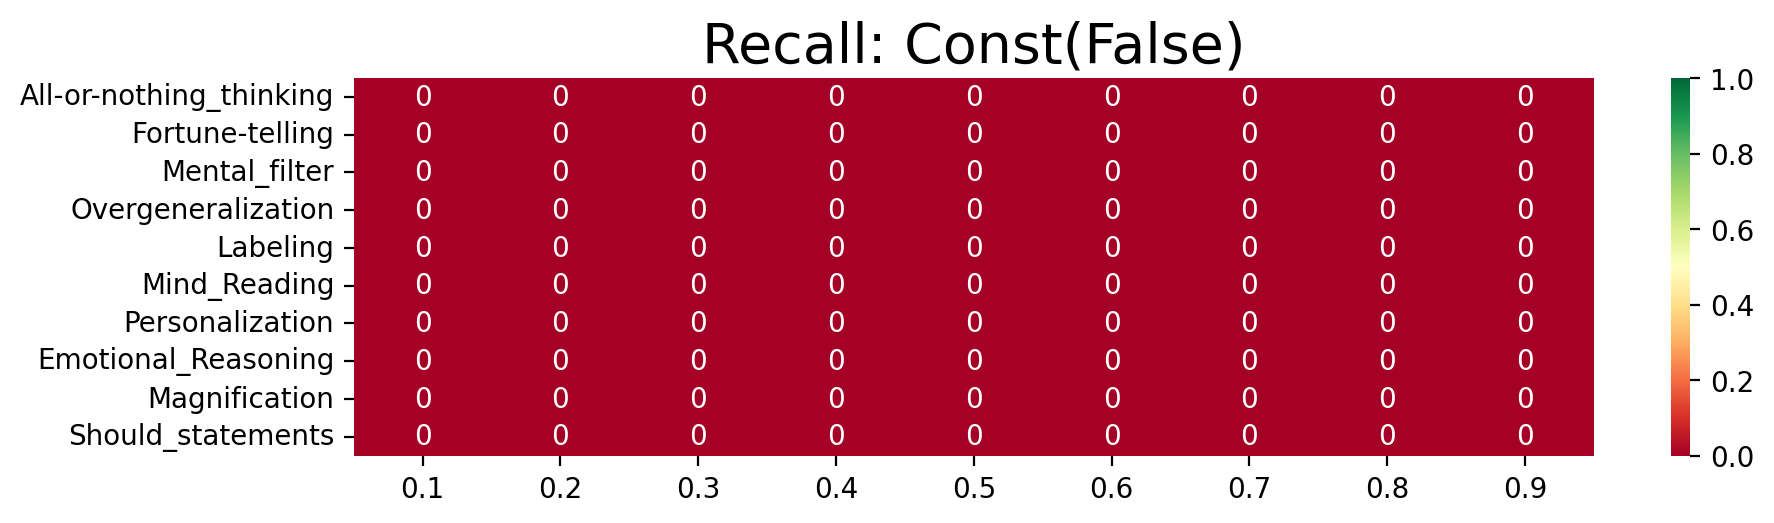

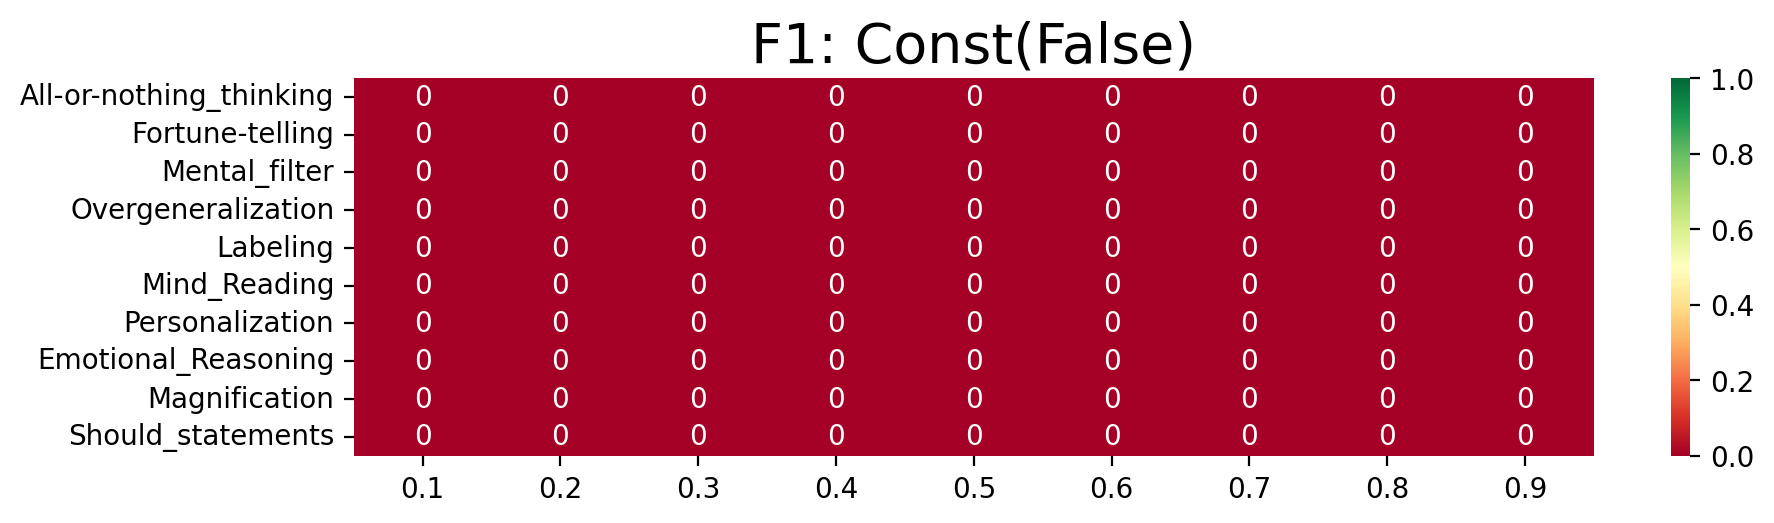

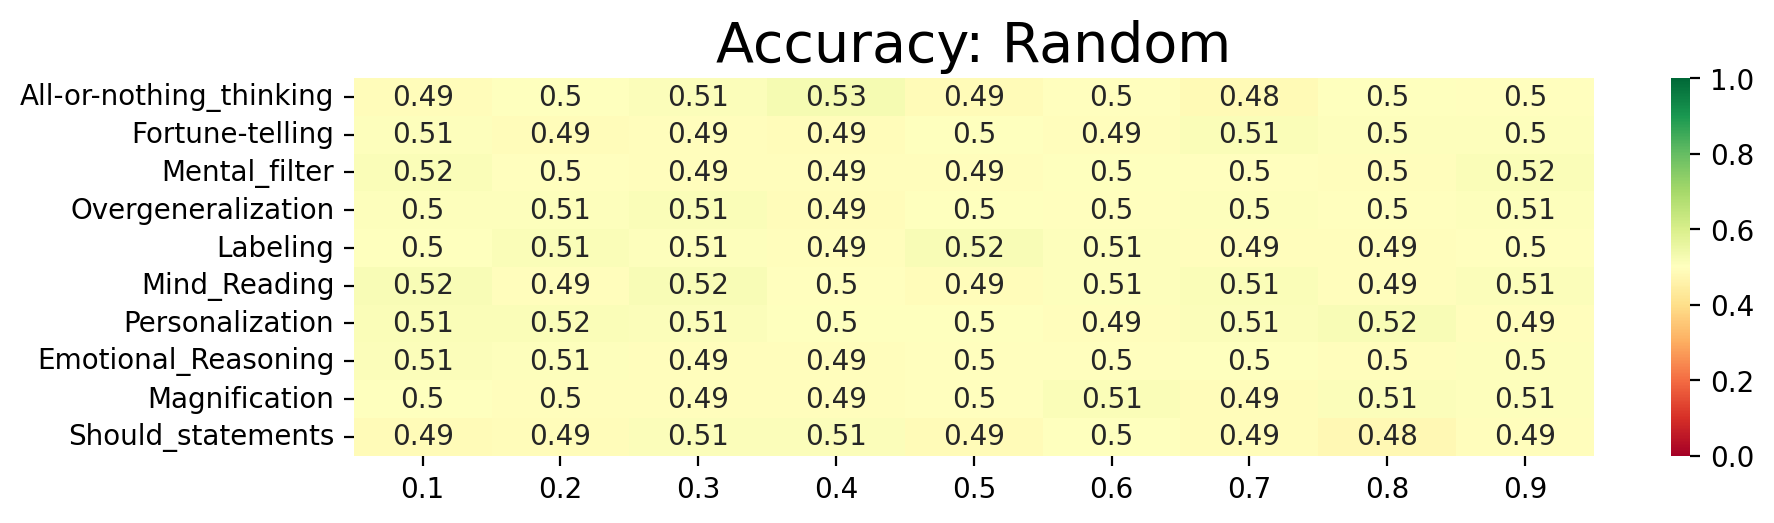

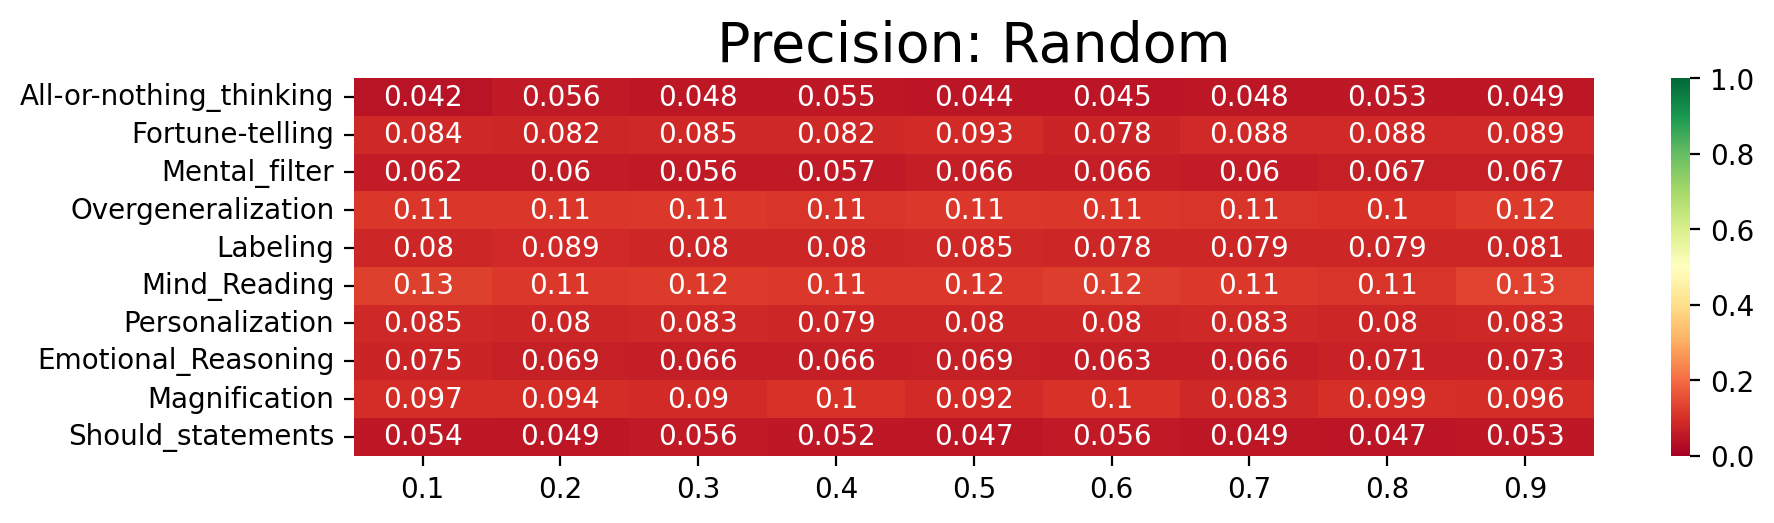

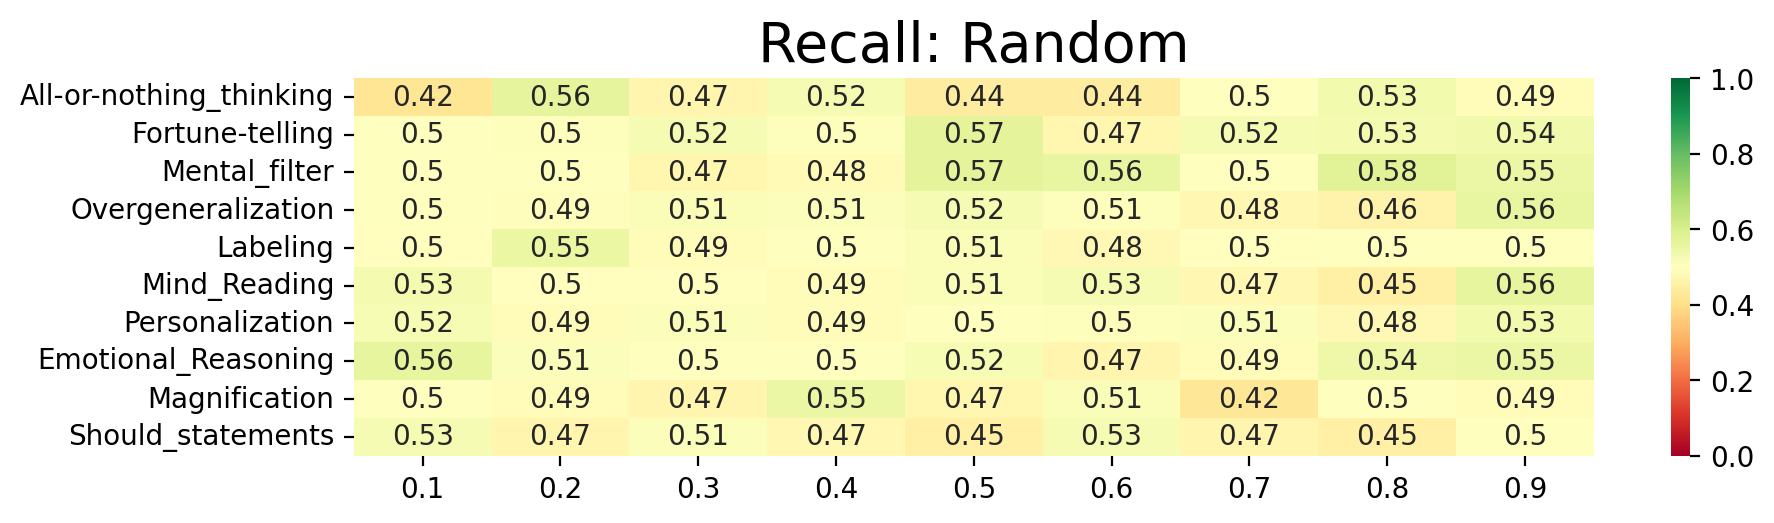

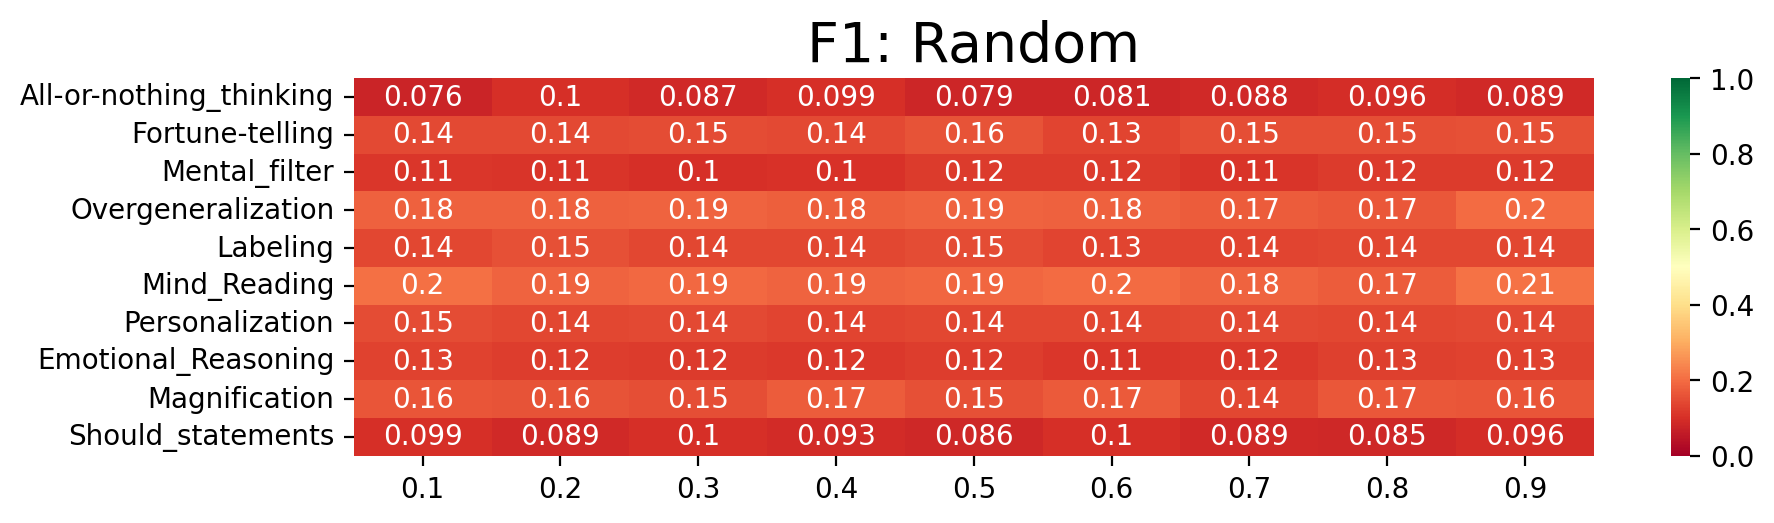

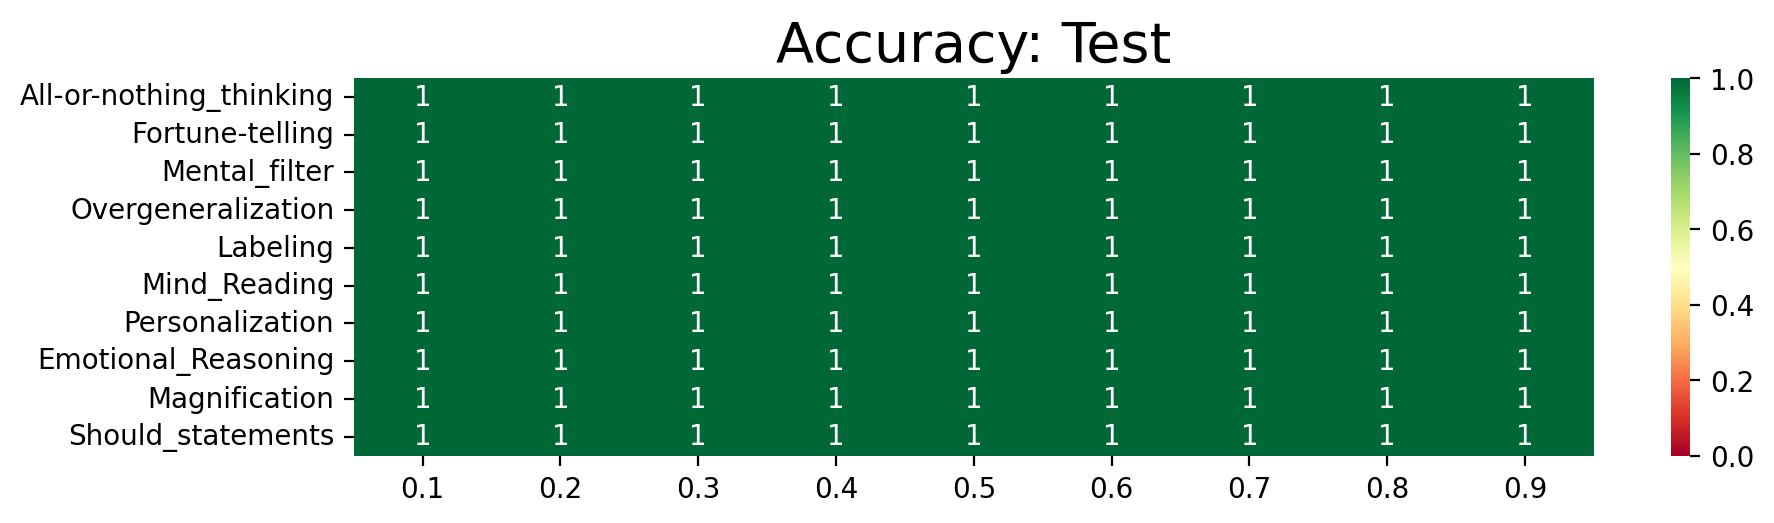

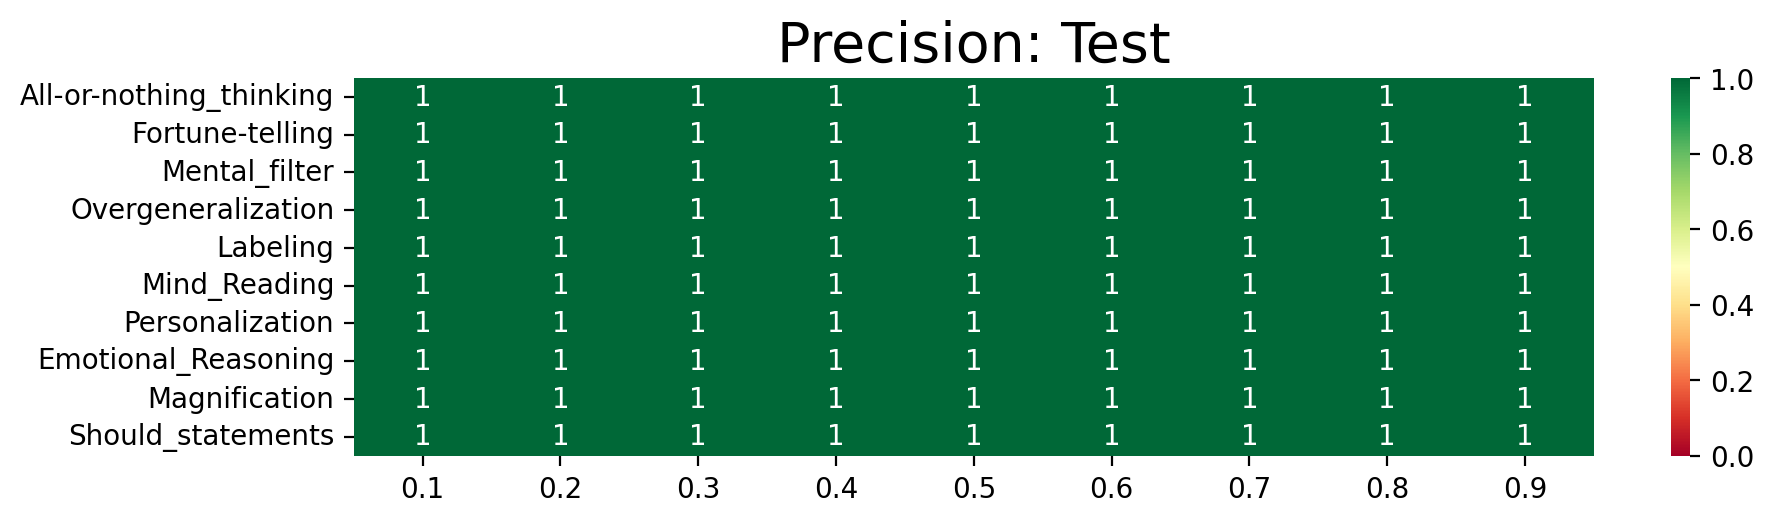

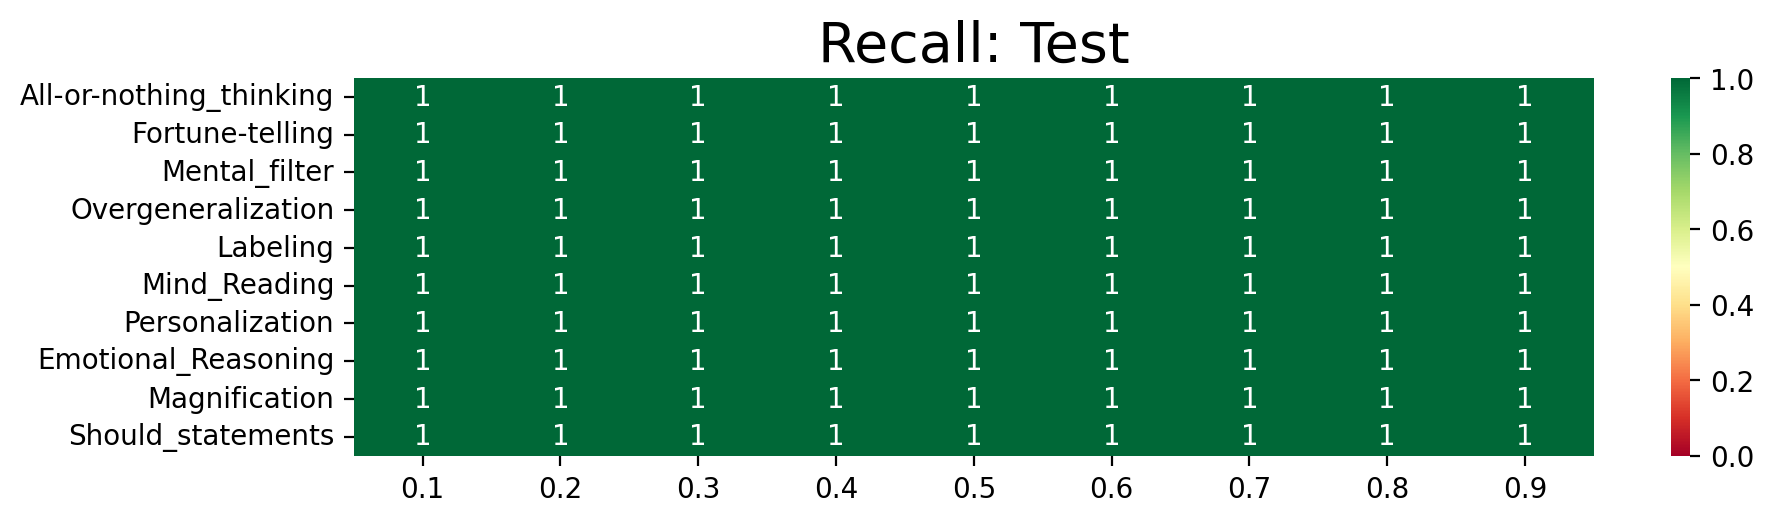

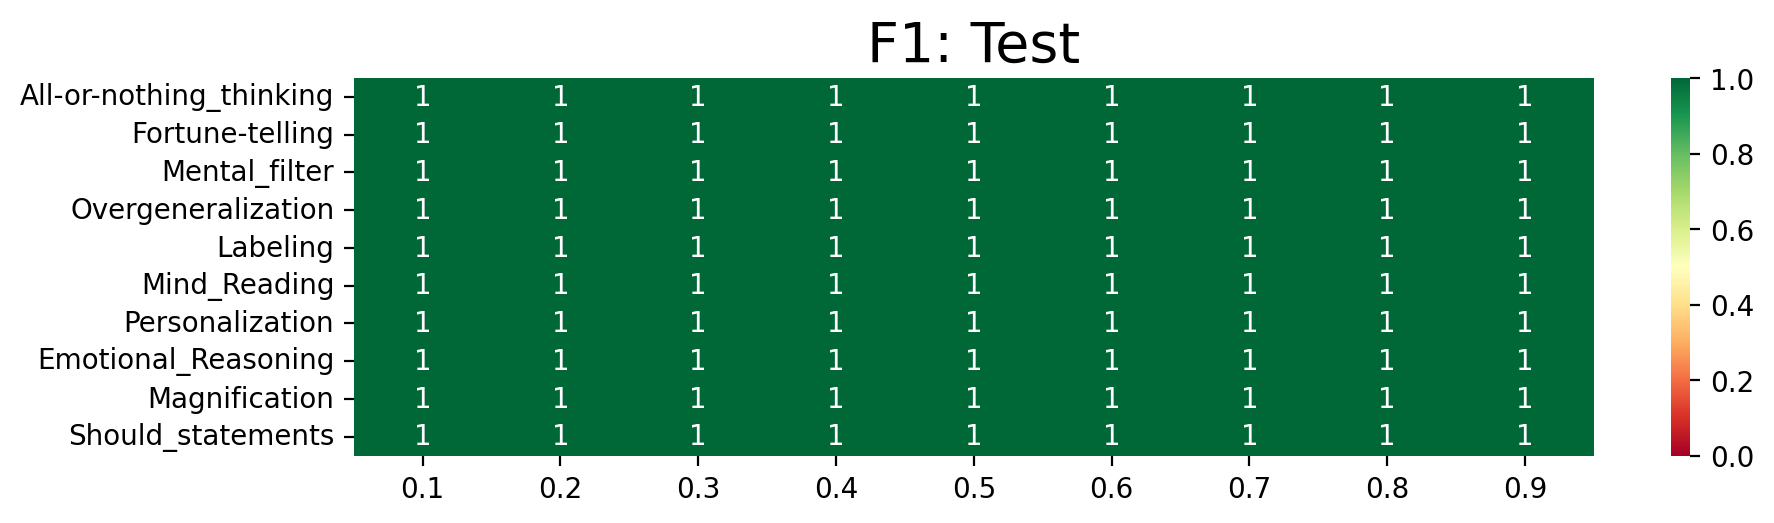

In [8]:
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
#thresholds = [0.1]

evaluators = {
    'Ours new (multi-class, joint), log': our_evaluator_tm,
    'Ours new (multi-class, joint), no log': our_evaluator_tm,
    'Const(True)': our_evaluator_true,
    'Const(False)': our_evaluator_false,
    'Random': our_evaluator_random,
    'Test': our_evaluator_test,
}

#for model in ['Ours new (multi-class, joint), log']:
for model in ['Ours new (multi-class, joint), log', 'Ours new (multi-class, joint), no log', 'Const(True)','Const(False)','Random','Test']:
#for model in ['Const(True)','Const(False)','Test']:
#for model in ['Const(False)']:
    pres = [[] for i in range(len(all_metrics))]
    recs = [[] for i in range(len(all_metrics))]
    f1s = [[] for i in range(len(all_metrics))]
    accs = [[] for i in range(len(all_metrics))]
    evaluator = evaluators[model]
    for t in thresholds:
        pre, rec, f1, acc = evaluate_tm_df(df3,models[model] if model in models else None,evaluator,t,debug=False)
        mi = 0
        for metric in all_metrics:
            pres[mi].append(pre[metric])
            recs[mi].append(rec[metric])
            f1s[mi].append(f1[metric])
            accs[mi].append(acc[metric])
            mi += 1
    
    matrix_plot(all_metrics, thresholds, accs, 1.0, title = f'Accuracy: {model}', vmin = 0, vmax = 1.0, titlefontsize = 20, dpi = 200, width = 10)

    matrix_plot(all_metrics, thresholds, pres, 1.0, title = f'Precision: {model}', vmin = 0, vmax = 1.0, titlefontsize = 20, dpi = 200, width = 10)

    matrix_plot(all_metrics, thresholds, recs, 1.0, title = f'Recall: {model}', vmin = 0, vmax = 1.0, titlefontsize = 20, dpi = 200, width = 10)

    matrix_plot(all_metrics, thresholds, f1s, 1.0, title = f'F1: {model}', vmin = 0, vmax = 1.0, titlefontsize = 20, dpi = 200, width = 10)


In [ ]:
#TODO learn

In [11]:
def df2labeled(df,binary=False):
    data = []
    for _, row in df.iterrows():
        # Text identification: first, check the 2nd column; if NaN, take the text from the 1st column
        text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
        if not binary:
            primary_distortion = row.iloc[2]  # The primary cognitive distortion from the 3rd column
            secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else None  # The secondary distortion from the 4th column, if present
        else:
            primary_distortion = 'Distortion' if row.iloc[2] != 'No Distortion' else 'No Distortion'
            secondary_distortion = None
        cats = (primary_distortion,) if secondary_distortion is None else (primary_distortion,secondary_distortion)
        data.append((text, cats))
    return data


[('The voice are always fimilar (someone she knows) Im very concerned about this and hope it has nothing to do with my pregnancy while on active duty.',
  ('Personalization',)),
 ('I feel trapped inside my disgusting self and like I’m willing to do anything to escape it.I’m just afraid sometimes that since I’m not really thinking during these times that I might do something to myself–especially since I think during these times that I don’t deserve to get help or that I’m not worth disturbing people by calling them.',
  ('Labeling', 'Emotional Reasoning')),
 (' So I’ve been dating on and off this guy for almost 3 years. He is 3 years younger than me. During our relationship we had always had issues. First he wouldn’t call me, he would prefer to go out with his friends than me, he wouldn’t even remember the day of our anniversary, or things like that we kind of tried to work all that out but I’ve always felt that he really doesn’t love and care about me, even though he says he loves me. 

In [13]:
#test
df2labeled(df3[:3])

[('The voice are always fimilar (someone she knows) Im very concerned about this and hope it has nothing to do with my pregnancy while on active duty.',
  ('Personalization',)),
 ('I feel trapped inside my disgusting self and like I’m willing to do anything to escape it.I’m just afraid sometimes that since I’m not really thinking during these times that I might do something to myself–especially since I think during these times that I don’t deserve to get help or that I’m not worth disturbing people by calling them.',
  ('Labeling', 'Emotional Reasoning')),
 (' So I’ve been dating on and off this guy for almost 3 years. He is 3 years younger than me. During our relationship we had always had issues. First he wouldn’t call me, he would prefer to go out with his friends than me, he wouldn’t even remember the day of our anniversary, or things like that we kind of tried to work all that out but I’ve always felt that he really doesn’t love and care about me, even though he says he loves me. 

In [ ]:
#TODO learn


def learn_model(text_labels, ngram_max=4, inclusion_threshold=50, learner, tokenize = tokenizer_re, punct = None):
    model = learner.init()
    for text_label in text_labels:
        text = text_label[0]
        labels = text_label[1]
        
        tokens = [t for t in tokenize(text) if not (t in punct or t.isnumeric())] if clean_punct else tokenize(text)
        learner.count_labels(model,labels)    
        
        for n in range(1, n_max + 1):
            n_grams = build_ngrams(tokens, n)
            learner.count_ngrams(n_grams,labels)
            
    learner.normalize()
    return learner.export()
        

model = learn_model(df3, 4, 'FN', 50)

In [ ]:
# TODO

# 1) How do they get F1 0.95 on multi-class!?
# https://dergipark.org.tr/tr/pub/fumbd/issue/88821/1469178

# 2) Perform cross-split validation experiment with our "BEST" learning parameters

# 3) Compute average F1 with "error bars" on 
# a) "joint" on three splits
# b) cross-split on three splits

# 4) Test on "theirs" https://dergipark.org.tr/tr/pub/fumbd/issue/88821/1469178 synthetic dataset only!?

